In [1]:
import pandas as pd
from datetime import datetime
from tqdm.notebook import tqdm
import pandas_profiling
import numpy as np

from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
import phik

import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

register_matplotlib_converters()
plt.style.use('fivethirtyeight')

from pylab import rcParams
rcParams['figure.figsize'] = 11, 9 #Changes default matplotlib plots to this size

In [22]:
raw_data = pd.read_csv('./actuals.csv')
timestamp = []

for row in tqdm(raw_data.timestamp.tolist()):

    tstamp = datetime.strptime(row,'%d/%b/%Y %H:%M')
    timestamp.append(tstamp)
    
raw_data['timestamp'] = timestamp
df = raw_data
df.set_index('timestamp',inplace=True)
df.index = pd.to_datetime(raw_data.index, format='%Y-%m-%d %H:%M:%S')

In [23]:
raw_data.columns = ['load', 't1', 't2', 't3']
raw_data

load    t1         t2      t3
timestamp                                                
2014-07-24 12:30:00   499.247996  21.5  21.545455  19.000
2014-07-24 12:45:00   530.257188  21.0  21.818182  19.000
2014-07-24 13:00:00   477.541561  21.5  21.800000  19.000
2014-07-24 13:15:00   463.587425  22.0  21.854545  19.000
2014-07-24 13:30:00   395.367202  22.0  21.909091  19.000
...                          ...   ...        ...     ...
2016-05-26 19:15:00  1821.790047  24.0  24.727273  22.000
2016-05-26 19:30:00  1581.468807  24.0  24.454545  22.000
2016-05-26 19:45:00   784.532565  24.0  24.181818  22.000
2016-05-26 20:00:00   541.110405  23.8  24.000000  21.700
2016-05-26 20:15:00   680.651771  22.0  23.454545  21.925

[53761 rows x 4 columns]

In [24]:
# df['energy_consumption'].interpolate(method='linear', inplace=True)

In [25]:
# see: https://www.kaggle.com/robikscube/starter-hourly-energy-consumption
df['dow'] = df.index.dayofweek
df['doy'] = df.index.dayofyear
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['hour'] = df.index.hour
df['weekday'] = df.index.day_name()
df['woy'] = df.index.weekofyear
df['dom'] = df.index.day # Day of Month
df['date'] = df.index.date 

In [26]:
df.iloc[:60]

load         t1         t2         t3  dow  doy  \
timestamp                                                                    
2014-07-24 12:30:00  499.247996  21.500000  21.545455  19.000000    3  205   
2014-07-24 12:45:00  530.257188  21.000000  21.818182  19.000000    3  205   
2014-07-24 13:00:00  477.541561  21.500000  21.800000  19.000000    3  205   
2014-07-24 13:15:00  463.587425  22.000000  21.854545  19.000000    3  205   
2014-07-24 13:30:00  395.367202  22.000000  21.909091  19.000000    3  205   
2014-07-24 13:45:00  393.816742  22.000000  21.963636  19.000000    3  205   
2014-07-24 14:00:00  345.752494  21.800000  22.000000  19.200000    3  205   
2014-07-24 14:15:00  376.761686  21.000000  22.000000  19.800000    3  205   
2014-07-24 14:30:00  468.238804  21.500000  22.000000  20.000000    3  205   
2014-07-24 14:45:00  513.202132  22.000000  22.000000  20.000000    3  205   
2014-07-24 15:00:00  496.147077  22.000000  22.000000  20.333333    3  205   
2014-07-24 15:15:00  477.541561  22.000000  22.000000  20.833333    3  205   
2014-07-24 15:30:00  500.798455  22.000000  22.000000  21.000000    3  205   
2014-07-24 15:45:00  466.688344  22.000000  22.000000  21.000000    3  205   
2014-07-24 16:00:00  468.238804  22.000000  21.800000  21.000000    3  205   
2014-07-24 16:15:00  418.624096  22.000000  21.854545  21.000000    3  205   
2014-07-24 16:30:00  427.926854  22.000000  21.909091  21.333333    3  205   
2014-07-24 16:45:00  567.468219  22.000000  21.963636  21.833333    3  205   
2014-07-24 17:00:00  527.156269  22.000000  22.400000  21.400000    3  205   
2014-07-24 17:15:00  465.137884  23.000000  22.563636  21.850000    3  205   
2014-07-24 17:30:00  407.770879  23.000000  22.727273  22.333333    3  205   
2014-07-24 17:45:00  499.247996  23.000000  22.890909  22.833333    3  205   
2014-07-24 18:00:00  454.284667  23.000000  22.800000  23.000000    3  205   
2014-07-24 18:15:00  440.330530  23.000000  22.581818  23.000000    3  205   
2014-07-24 18:30:00  268.229513  23.000000  22.363636  22.666667    3  205   
2014-07-24 18:45:00  483.743400  23.000000  22.145455  22.166667    3  205   
2014-07-24 19:00:00  513.202132  23.000000  22.400000  22.000000    3  205   
2014-07-24 19:15:00  538.009486  23.000000  22.290909  22.000000    3  205   
2014-07-24 19:30:00  516.303052  22.500000  22.181818  22.000000    3  205   
2014-07-24 19:45:00  485.293859  22.000000  22.072727  22.000000    3  205   
2014-07-24 20:00:00  248.073538  22.400000  22.000000  21.800000    3  205   
2014-07-24 20:15:00  271.330432  22.000000  22.000000  21.950000    3  205   
2014-07-24 20:30:00  175.201936  22.000000  22.000000  22.000000    3  205   
2014-07-24 20:45:00  167.449638  22.000000  22.000000  22.000000    3  205   
2014-07-24 21:00:00  172.101017  21.500000  21.600000  21.666667    3  205   
2014-07-24 21:15:00  179.853315  21.000000  21.436364  21.166667    3  205   
2014-07-24 21:30:00  182.954234  21.000000  21.272727  21.000000    3  205   
2014-07-24 21:45:00  310.091923  21.000000  21.109091  21.000000    3  205   
2014-07-24 22:00:00  300.789165  21.000000  21.200000  21.000000    3  205   
2014-07-24 22:15:00  297.688246  21.000000  21.145455  21.000000    3  205   
2014-07-24 22:30:00  297.688246  21.000000  21.090909  21.000000    3  205   
2014-07-24 22:45:00  300.789165  21.000000  21.036364  21.000000    3  205   
2014-07-24 23:00:00  331.798357  21.000000  21.000000  20.900000    3  205   
2014-07-24 23:15:00  353.504792  20.950000  21.000000  20.975000    3  205   
2014-07-24 23:30:00  355.055252  20.900000  21.000000  21.000000    3  205   
2014-07-24 23:45:00  358.156171  20.850000  21.000000  21.000000    3  205   
2014-07-25 00:00:00  300.789165  20.800000  20.800000  20.666667    4  206   
2014-07-25 00:15:00  297.688246  20.750000  20.581818  20.166667    4  206   
2014-07-25 00:30:00  260.477215  20.700000  20.363636  20.000000    4  206   
2014-07-25 00:45:00  255.825836  20.650000  20.14

In [39]:
pandas_profiling.ProfileReport(df)

## Inference from the profiling

### Correlation:
The correlation matrix indicates the variables "t1,t2,t3,dow,doy ,woy ,month" has a high correlation with the energy consumption (load) in Phik correlation


### Descriptive statistics
Skewness is a measure of a dataset's symmetry or lack of symmetry. Perfectly symmetric data (normal distribution) would have a skewness of 0.As can be seen the skewness is greater than 1 which tells us that data is highly skewed.

Reference: https://towardsdatascience.com/skewed-data-a-problem-to-your-statistical-model-9a6b5bb74e37

So in skewed data, the tail region may act as an outlier for the statistical model and we know that outliers adversely affect the model’s performance especially regression-based models. There are statistical model that are robust to outlier like a Tree-based models but it will limit the possibility to try other models. So there is a necessity to transform the skewed data to close enough to a Gaussian distribution or Normal distribution. This will allow us to try more number of statistical model.

In [40]:
heatmap_data = df.copy()

# First we need to add weekdays as a column
heatmap_data['Hour'] = df.index.hour

# Next we add the year as column and group the data up to annual day of week level
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Hour']).sum()

# Reset index 
heatmap_data = heatmap_data.reset_index()

# We drop off 2018 because it's not a full year
# heatmap_data = heatmap_data[heatmap_data['Year'] != 2018]

# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Hour', values='load')

heatmap_data.head(100)


Hour            0             1             2             3             4   \
Year                                                                         
2014  2.663488e+05  2.644030e+05  2.573794e+05  2.555778e+05  2.580663e+05   
2015  1.452712e+06  1.442887e+06  1.441373e+06  1.425955e+06  1.431604e+06   
2016  7.366621e+05  7.359039e+05  7.303378e+05  7.244755e+05  7.188334e+05   

Hour            5             6             7             8             9   \
Year                                                                         
2014  2.674915e+05  3.128409e+05  5.459556e+05  6.768702e+05  7.046358e+05   
2015  1.642095e+06  1.780176e+06  2.711678e+06  2.946252e+06  3.042966e+06   
2016  8.047769e+05  8.695226e+05  1.204613e+06  1.434588e+06  1.463201e+06   

Hour  ...            14            15            16            17  \
Year  ...                                                           
2014  ...  5.458626e+05  5.563204e+05  5.670791e+05  5.725646e+05   
2015  ...  2.959562e+06  2.965932e+06  3.007910e+06  3.052522e+06   
2016  ...  1.224581e+06  1.214314e+06  1.198941e+06  1.253985e+06   

Hour            18            19            20            21            22  \
Year                                                                         
2014  5.367707e+05  3.860179e+05  2.678388e+05  2.744903e+05  2.790533e+05   
2015  2.743600e+06  1.862389e+06  1.550196e+06  1.510368e+06  1.501248e+06   
2016  1.240583e+06  9.927174e+05  7.817883e+05  7.423802e+05  7.324464e+05   

Hour            23  
Year                
2014  2.715041e+05  
2015  1.477210e+06  
2016  7.287951e+05  

[3 rows x 24 columns]

Text(0.5, 1.0, 'Heatmap - by Hour of Day')

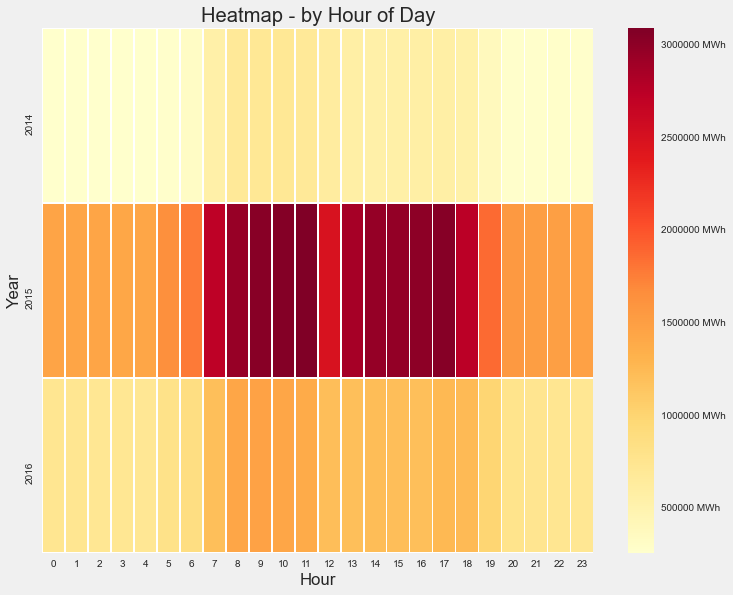

In [41]:
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f MWh'}).set_title('Heatmap - by Hour of Day')

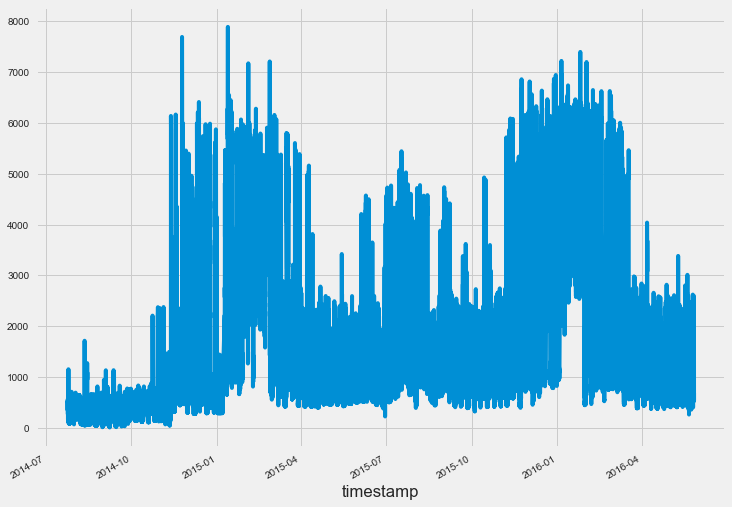

In [42]:
df['load'].plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb278c15fd0>,
      dtype=object)

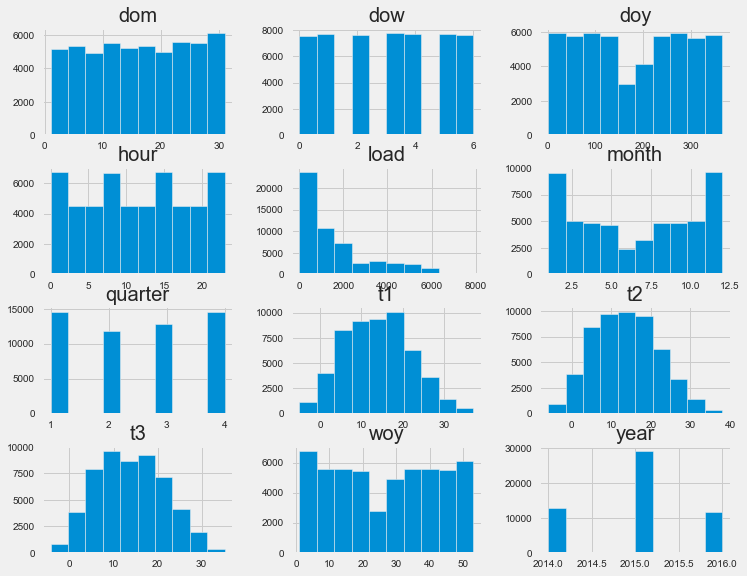

In [43]:
df.hist()

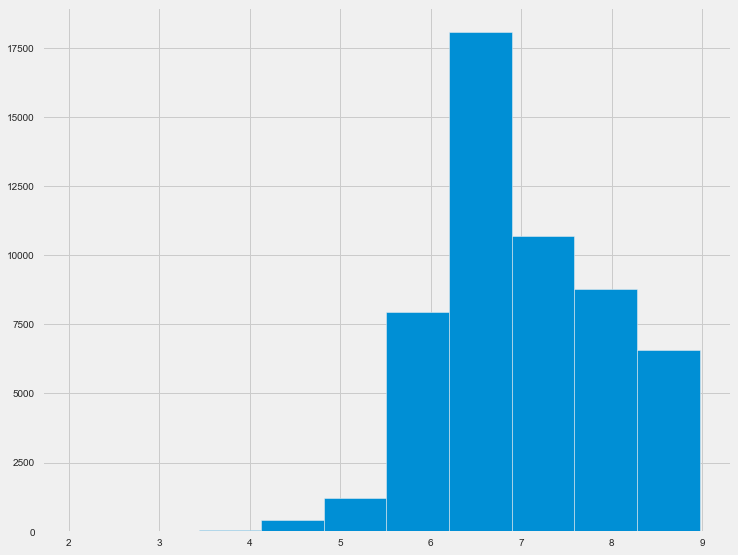

In [44]:
df['load'].apply(np.log).hist()

In [45]:
df.columns

Index(['load', 't1', 't2', 't3', 'dow', 'doy', 'year', 'month', 'quarter',
       'hour', 'weekday', 'woy', 'dom', 'date'],
      dtype='object')

/Users/siddesh.suseela/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


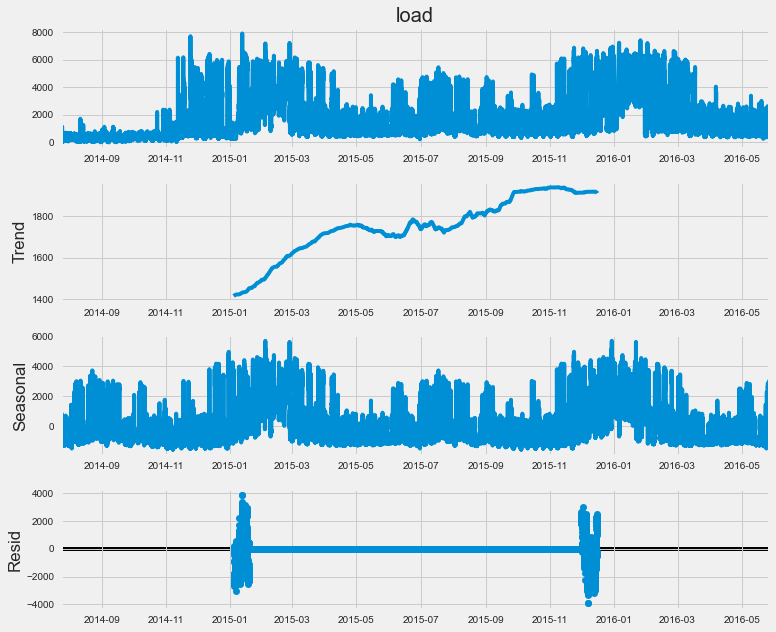

In [46]:
series = df['load']
frequency = 24*365*3

# decomposing the time-series, with the frequency being 24 hours per 365 days
decomposed = seasonal_decompose(series, model='additive', period=frequency)
fig = decomposed.plot()
fig.show()

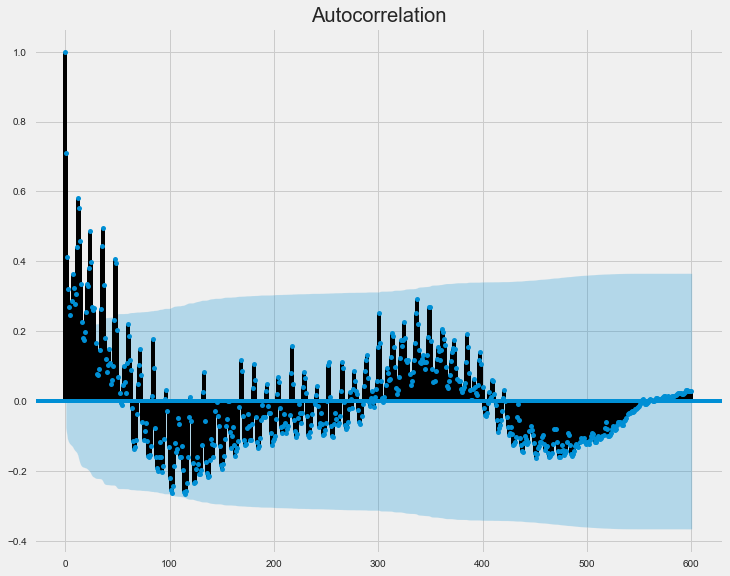

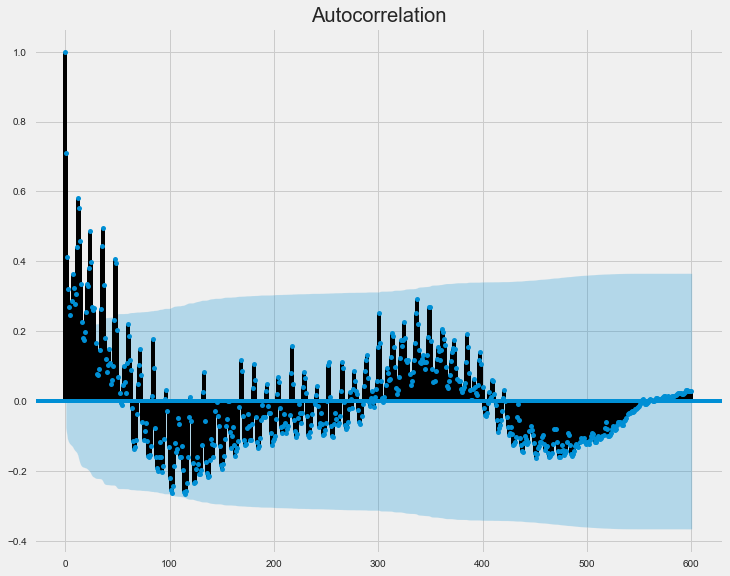

In [47]:
daily_data = df.resample(rule='D').sum()
daily_data = daily_data.asfreq('D')
daily_data = daily_data.drop([daily_data.index.min(), daily_data.index.max()])

plot_acf(daily_data['load'],lags=600) #alpha 1 suppresses CI
plot_acf(daily_data['load'],lags=600) #alpha 1 suppresses CI
plt.show()

In [48]:
daily_data

load           t1           t2           t3  dow    doy  \
timestamp                                                                      
2014-07-25   38945.995054  2246.536364  2217.163638  2221.149998  384  19776   
2014-07-26   16844.193249  1914.627272  1881.263239  1919.374996  480  19872   
2014-07-27   17563.606510  2107.836364  2129.381814  2037.608332  576  19968   
2014-07-28   34758.203639  2225.000000  2281.200001  2312.125000    0  20064   
2014-07-29   36443.553230  2074.300000  2084.727273  2191.250000   96  20160   
...                   ...          ...          ...          ...  ...    ...   
2016-05-21   59777.970425  1936.300000  1960.963636  1901.500002  480  13632   
2016-05-22   50493.818256  1950.800000  2004.727276  1958.191664  576  13728   
2016-05-23  121123.455521  1556.600000  1606.992069  1650.833332    0  13824   
2016-05-24  132331.728076  1535.100000  1602.505135  1486.333332   96  13920   
2016-05-25  105519.629968  1770.400000  1844.000000  1734.333334  192  14016   

              year  month  quarter  hour   woy   dom  
timestamp                                             
2014-07-25  193344    672      288  1104  2880  2400  
2014-07-26  193344    672      288  1104  2880  2496  
2014-07-27  193344    672      288  1104  2880  2592  
2014-07-28  193344    672      288  1104  2976  2688  
2014-07-29  193344    672      288  1104  2976  2784  
...            ...    ...      ...   ...   ...   ...  
2016-05-21  193536    480      192  1104  1920  2016  
2016-05-22  193536    480      192  1104  1920  2112  
2016-05-23  193536    480      192  1104  2016  2208  
2016-05-24  193536    480      192  1104  2016  2304  
2016-05-25  193536    480      192  1104  2016  2400  

[671 rows x 12 columns]

In [91]:
weekly_data = df.resample(rule='h').mean()
weekly_data = weekly_data.asfreq('h')

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [30]:
weekly_data  

load      t1         t2         t3  dow    doy  \
timestamp                                                                    
2014-07-24 12:00:00   514.752592  21.250  21.681818  19.000000  3.0  205.0   
2014-07-24 13:00:00   432.578233  21.875  21.881818  19.000000  3.0  205.0   
2014-07-24 14:00:00   425.988779  21.575  22.000000  19.750000  3.0  205.0   
2014-07-24 15:00:00   485.293859  22.000  22.000000  20.791666  3.0  205.0   
2014-07-24 16:00:00   470.564493  22.000  21.881818  21.291666  3.0  205.0   
...                          ...     ...        ...        ...  ...    ...   
2016-05-26 16:00:00  2073.352119  25.875  26.527273  22.791666  3.0  147.0   
2016-05-26 17:00:00  2476.859234  25.575  26.881818  22.822916  3.0  147.0   
2016-05-26 18:00:00  2133.820044  25.000  26.181818  22.104166  3.0  147.0   
2016-05-26 19:00:00  1497.743988  24.125  24.590909  22.000000  3.0  147.0   
2016-05-26 20:00:00   610.881088  22.900  23.727272  21.812500  3.0  147.0   

                       year  month  quarter  hour   woy   dom  
timestamp                                                      
2014-07-24 12:00:00  2014.0    7.0      3.0  12.0  30.0  24.0  
2014-07-24 13:00:00  2014.0    7.0      3.0  13.0  30.0  24.0  
2014-07-24 14:00:00  2014.0    7.0      3.0  14.0  30.0  24.0  
2014-07-24 15:00:00  2014.0    7.0      3.0  15.0  30.0  24.0  
2014-07-24 16:00:00  2014.0    7.0      3.0  16.0  30.0  24.0  
...                     ...    ...      ...   ...   ...   ...  
2016-05-26 16:00:00  2016.0    5.0      2.0  16.0  21.0  26.0  
2016-05-26 17:00:00  2016.0    5.0      2.0  17.0  21.0  26.0  
2016-05-26 18:00:00  2016.0    5.0      2.0  18.0  21.0  26.0  
2016-05-26 19:00:00  2016.0    5.0      2.0  19.0  21.0  26.0  
2016-05-26 20:00:00  2016.0    5.0      2.0  20.0  21.0  26.0  

[16137 rows x 12 columns]

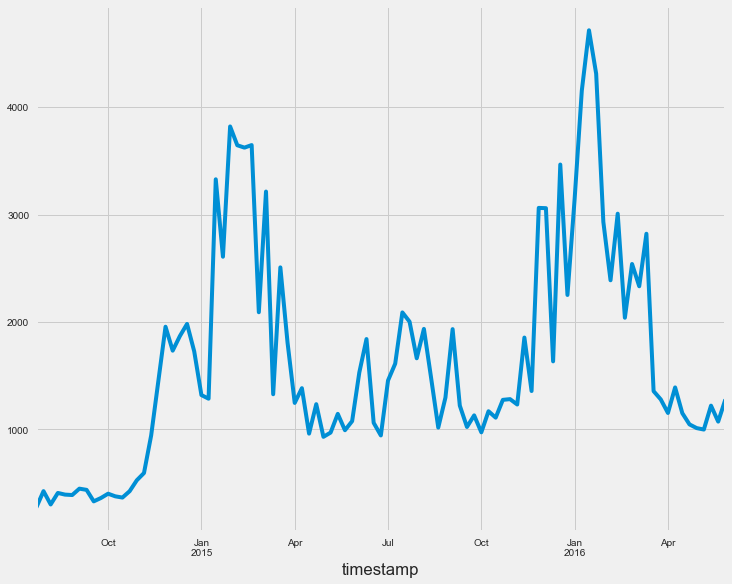

In [51]:
weekly_data['load'].plot()

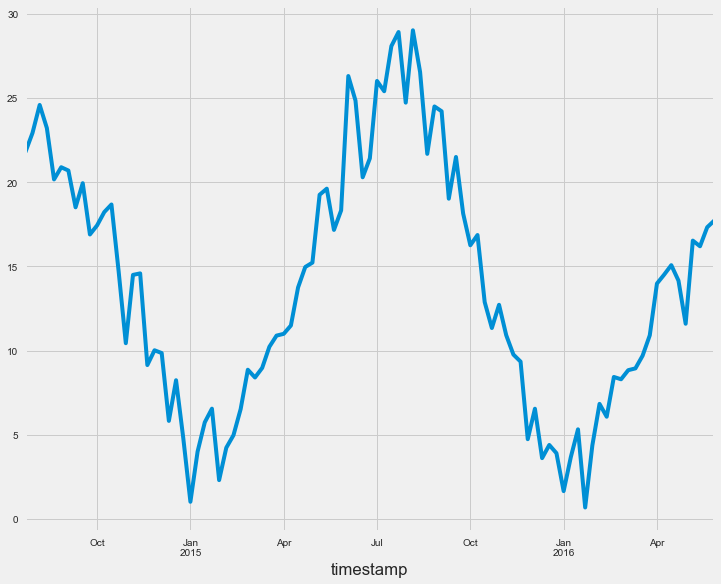

In [52]:
weekly_data['t1'].plot()

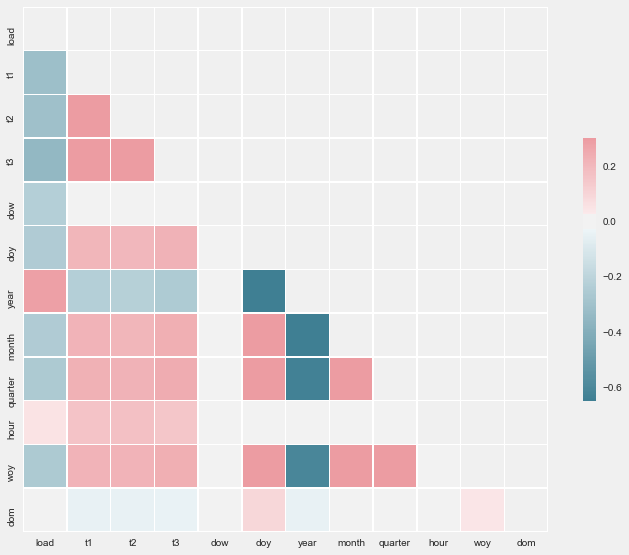

In [53]:
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [95]:
# from phik import report
# rep = report.correlation_report(df, significance_threshold=3, correlation_threshold=0.5)

# Result

#### Features
Given all the data analysis, the best features that could be used to forcast the load is using **t1,t2,t3,doy,month,woy**. In addition to that the features that need to be added are the following:

#### Static Features
                    1. Time --> doy (cyclic)
                    2. Time --> month (cyclic)
                    3. Time --> dow (cyclic)
                    3. Time --> woy (cyclic)
                    4. Temp --> t1
                    5. Temp --> t2
                    6. Temp --> t3
                    7. Load --> (t-12)days Difference Load

#### Computed Features

                    1. Time --> Add whether the given date is a working day or not -> categorical
                    2. Load --> Last 2 weeks (14 days) average.
                    3. Load --> Ratio of at t-7days and t-14days
                    4. Load --> Last week's average
                    5. Load --> Ratio of t-1hr and (t-1hr) in the past week

#### New Things that we are doing

                    1. Making time cyclic -> because to capture the weekend effect, 0-sunday and 6-saturday, but it would be difficult for our model to learn the features effectiveley.
                    
                    2. Use ensemble tree based models inaddition to neural networks
                    
                    3. Adding ratios to capture the relative features
                    
                    4. Adding working days as categorical data.

In [85]:
raw_data = pd.read_csv('./actuals.csv')
timestamp = []

for row in tqdm(raw_data.timestamp.tolist()):

    tstamp = datetime.strptime(row,'%d/%b/%Y %H:%M')
    timestamp.append(tstamp)
    
raw_data['timestamp'] = timestamp

raw_data.set_index('timestamp',inplace=True)
raw_data.index = pd.to_datetime(raw_data.index, format='%Y-%m-%d %H:%M:%S')

# raw_data.columns = ['load', 't1', 't2', 't3']
raw_data.columns = ['load', 't1', 't2', 't3']

df = raw_data.resample(rule='h').mean()
df = df.asfreq('h')

df['dow'] = df.index.dayofweek
df['doy'] = df.index.dayofyear
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['hour'] = df.index.hour
df['weekday'] = df.index.day_name()

df['woy'] = df.index.weekofyear
df['dom'] = df.index.day # Day of Month
df['date'] = df.index.date 

df['hr_sin'] = np.round(np.sin(df.hour*(2.*np.pi/24)), 15)
df['hr_cos'] = np.round(np.cos(df.hour*(2.*np.pi/24)), 15)

df['mnth_sin'] = np.round(np.sin((df.month-1)*(2.*np.pi/12)), 15)
df['mnth_cos'] = np.round(np.cos((df.month-1)*(2.*np.pi/12)), 15)

df['dow_sin'] = np.round(np.sin((df.dow)*(2.*np.pi/12)), 15)
df['dow_cos'] = np.round(np.cos((df.dow)*(2.*np.pi/12)), 15)

df['woy_sin'] = np.round(np.sin((df.woy-1)*(2.*np.pi/12)), 15)
df['woy_cos'] = np.round(np.cos((df.woy-1)*(2.*np.pi/12)), 15)

df['dom_sin'] = np.round(np.sin((df.dom-1)*(2.*np.pi/12)), 15)
df['dom_cos'] = np.round(np.cos((df.dom-1)*(2.*np.pi/12)), 15)

df['doy_sin'] = np.round(np.sin((df.doy-1)*(2.*np.pi/12)), 15)
df['doy_cos'] = np.round(np.cos((df.doy-1)*(2.*np.pi/12)), 15)

df.t1 = (df.t1 - 13.81)/(8.007)
df.t2 = (df.t2 - 13.69)/(8.184)
df.t3 = (df.t3 - 13.89)/(7.705)

# df.drop(['quarter', 'dom', 'date'], axis=1, inplace=True)

df.drop(['month', 'hour', 'weekday', 'quarter', 'dom', 'dow', 'date', 'doy', 'woy'], axis=1, inplace=True)

df['load'] = df['load'].apply(np.log)

is_working = [1]*len(df)
weekend = ['Saturday', 'Sunday']

for i, date in tqdm(enumerate(df.index.tolist())):
    day, month, day_name = date.day, date.month, date.day_name()
    holidays = [
        (day==1  and month==1),
        (day==6  and month==1),
        (day==21 and month==4),
        (day==25 and month==4),
        (day==1  and month==5),
        (day==2  and month==6),
        (day==15 and month==8),
        (day==1  and month==11),
        (day==8  and month==12),
        (day==25 and month==12),
        (day==26 and month==12),
        (day_name in weekend)
    ]
#     print(holidays)
    if any(holidays):
        is_working[i] = 0

df['working'] = is_working

In [86]:
df

load        t1        t2        t3  year    hr_sin  \
timestamp                                                                     
2014-07-24 12:00:00  6.243686  0.929187  0.976517  0.663206  2014  0.000000   
2014-07-24 13:00:00  6.069763  1.007244  1.000955  0.663206  2014 -0.258819   
2014-07-24 14:00:00  6.054413  0.969776  1.015396  0.760545  2014 -0.500000   
2014-07-24 15:00:00  6.184755  1.022855  1.015396  0.895739  2014 -0.707107   
2014-07-24 16:00:00  6.153933  1.022855  1.000955  0.960632  2014 -0.866025   
...                       ...       ...       ...       ...   ...       ...   
2016-05-26 16:00:00  7.636922  1.506807  1.568582  1.155310  2016 -0.866025   
2016-05-26 17:00:00  7.814747  1.469339  1.611903  1.159366  2016 -0.965926   
2016-05-26 18:00:00  7.665669  1.397527  1.526371  1.066083  2016 -1.000000   
2016-05-26 19:00:00  7.311715  1.288248  1.331978  1.052563  2016 -0.965926   
2016-05-26 20:00:00  6.414902  1.135257  1.226451  1.028228  2016 -0.866025   

                       hr_cos  mnth_sin  mnth_cos  dow_sin  dow_cos   woy_sin  \
timestamp                                                                       
2014-07-24 12:00:00 -1.000000  0.000000      -1.0      1.0      0.0  0.500000   
2014-07-24 13:00:00 -0.965926  0.000000      -1.0      1.0      0.0  0.500000   
2014-07-24 14:00:00 -0.866025  0.000000      -1.0      1.0      0.0  0.500000   
2014-07-24 15:00:00 -0.707107  0.000000      -1.0      1.0      0.0  0.500000   
2014-07-24 16:00:00 -0.500000  0.000000      -1.0      1.0      0.0  0.500000   
...                       ...       ...       ...      ...      ...       ...   
2016-05-26 16:00:00 -0.500000  0.866025      -0.5      1.0      0.0 -0.866025   
2016-05-26 17:00:00 -0.258819  0.866025      -0.5      1.0      0.0 -0.866025   
2016-05-26 18:00:00 -0.000000  0.866025      -0.5      1.0      0.0 -0.866025   
2016-05-26 19:00:00  0.258819  0.866025      -0.5      1.0      0.0 -0.866025   
2016-05-26 20:00:00  0.500000  0.866025      -0.5      1.0      0.0 -0.866025   

                      woy_cos  dom_sin   dom_cos       doy_sin  doy_cos  \
timestamp                                                                 
2014-07-24 12:00:00 -0.866025     -0.5  0.866025 -1.100000e-14      1.0   
2014-07-24 13:00:00 -0.866025     -0.5  0.866025 -1.100000e-14      1.0   
2014-07-24 14:00:00 -0.866025     -0.5  0.866025 -1.100000e-14      1.0   
2014-07-24 15:00:00 -0.866025     -0.5  0.866025 -1.100000e-14      1.0   
2014-07-24 16:00:00 -0.866025     -0.5  0.866025 -1.100000e-14      1.0   
...                       ...      ...       ...           ...      ...   
2016-05-26 16:00:00 -0.500000      0.5  0.866025  8.660254e-01      0.5   
2016-05-26 17:00:00 -0.500000      0.5  0.866025  8.660254e-01      0.5   
2016-05-26 18:00:00 -0.500000      0.5  0.866025  8.660254e-01      0.5   
2016-05-26 19:00:00 -0.500000      0.5  0.866025  8.660254e-01      0.5   
2016-05-26 20:00:00 -0.500000      0.5  0.866025  8.660254e-01      0.5   

                     working  
timestamp                     
2014-07-24 12:00:00        1  
2014-07-24 13:00:00        1  
2014-07-24 14:00:00        1  
2014-07-24 15:00:00        1  
2014-07-24 16:00:00        1  
...                      ...  
2016-05-26 16:00:00        1  
2016-05-26 17:00:00        1  
2016-05-26 18:00:00        1  
2016-05-26 19:00:00        1  
2016-05-26 20:00:00        1  

[16137 rows x 18 columns]

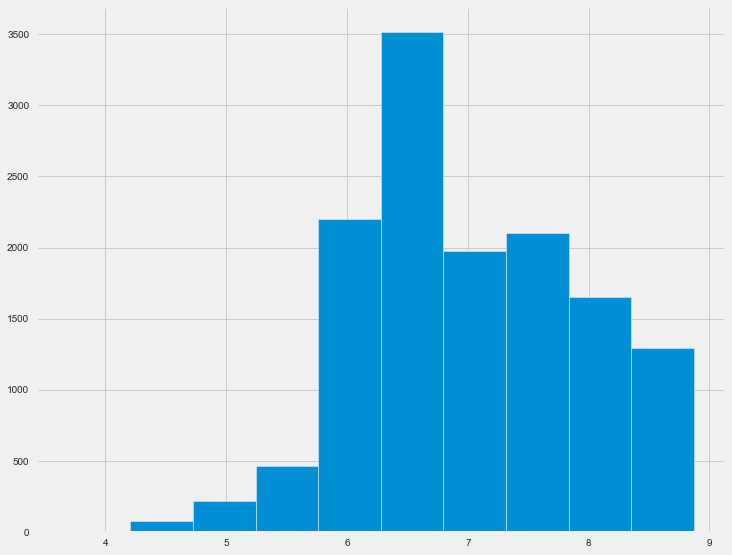

In [87]:
df['load'].hist()

In [88]:
df['load'].describe()

count    13499.000000
mean         7.011750
std          0.905102
min          3.686986
25%          6.360465
50%          6.856100
75%          7.683671
max          8.872580
Name: load, dtype: float64

In [89]:
df.reset_index(drop=True, inplace=True)
df

load        t1        t2        t3  year    hr_sin    hr_cos  \
0      6.243686  0.929187  0.976517  0.663206  2014  0.000000 -1.000000   
1      6.069763  1.007244  1.000955  0.663206  2014 -0.258819 -0.965926   
2      6.054413  0.969776  1.015396  0.760545  2014 -0.500000 -0.866025   
3      6.184755  1.022855  1.015396  0.895739  2014 -0.707107 -0.707107   
4      6.153933  1.022855  1.000955  0.960632  2014 -0.866025 -0.500000   
...         ...       ...       ...       ...   ...       ...       ...   
16132  7.636922  1.506807  1.568582  1.155310  2016 -0.866025 -0.500000   
16133  7.814747  1.469339  1.611903  1.159366  2016 -0.965926 -0.258819   
16134  7.665669  1.397527  1.526371  1.066083  2016 -1.000000 -0.000000   
16135  7.311715  1.288248  1.331978  1.052563  2016 -0.965926  0.258819   
16136  6.414902  1.135257  1.226451  1.028228  2016 -0.866025  0.500000   

       mnth_sin  mnth_cos  dow_sin  dow_cos   woy_sin   woy_cos  dom_sin  \
0      0.000000      -1.0      1.0      0.0  0.500000 -0.866025     -0.5   
1      0.000000      -1.0      1.0      0.0  0.500000 -0.866025     -0.5   
2      0.000000      -1.0      1.0      0.0  0.500000 -0.866025     -0.5   
3      0.000000      -1.0      1.0      0.0  0.500000 -0.866025     -0.5   
4      0.000000      -1.0      1.0      0.0  0.500000 -0.866025     -0.5   
...         ...       ...      ...      ...       ...       ...      ...   
16132  0.866025      -0.5      1.0      0.0 -0.866025 -0.500000      0.5   
16133  0.866025      -0.5      1.0      0.0 -0.866025 -0.500000      0.5   
16134  0.866025      -0.5      1.0      0.0 -0.866025 -0.500000      0.5   
16135  0.866025      -0.5      1.0      0.0 -0.866025 -0.500000      0.5   
16136  0.866025      -0.5      1.0      0.0 -0.866025 -0.500000      0.5   

        dom_cos       doy_sin  doy_cos  working  
0      0.866025 -1.100000e-14      1.0        1  
1      0.866025 -1.100000e-14      1.0        1  
2      0.866025 -1.100000e-14      1.0        1  
3      0.866025 -1.100000e-14      1.0        1  
4      0.866025 -1.100000e-14      1.0        1  
...         ...           ...      ...      ...  
16132  0.866025  8.660254e-01      0.5        1  
16133  0.866025  8.660254e-01      0.5        1  
16134  0.866025  8.660254e-01      0.5        1  
16135  0.866025  8.660254e-01      0.5        1  
16136  0.866025  8.660254e-01      0.5        1  

[16137 rows x 18 columns]

In [90]:
df.to_csv('./data.csv', index=False)

So guys! We are currently splitting into two teams to work on decision tree algorithm XG boost (DS102) and experimenting with neural networks. The following will is a detailed description about each of the task:

1. Decision Trees (Aru, Abhinav, Shiv, Siddesh):
    
    
    * 1a. Complete the DS102 given in the auto caffe.
    * 1b. Learn about ensemble methods (Reference: https://towardsdatascience.com/exploring-xgboost-4baf9ace0cf6)
        In a nutshell ensemble learning methods has three parts and that are Bagging, Boosting and Stacking. We'll be using Boosting for the decision tree algorithm.
    * 1c. Experiment with XG Boosting with decision trees 
    
2. Experimenting with Neural Network (Naseer, Shiv, Siddesh):

    * 2a. Implementing the additional functions and features given the following videos into pipeline, Compelete NN102.
    
        Session 6: Difference, Momentum, and Force Inputs - https://www.youtube.com/watch?v=Ugp-_wul8-4
        
        Session 7: Input Scaling and Dimensional Reduction - https://www.youtube.com/watch?v=6Z4nc83MIgQ
        
        Session 8: Square Perceptrons / Momentum & Force Losses - https://www.youtube.com/watch?v=oaIFx7RX1Co
       
    * 2b. Start Experimenting to reduce the loss as much as possible and try different activation functions and feture engineering. 
    
    
All these tasks have to be completed by Sunday (Ideal case) and in the worst case we have to complete everything by monday. Pls make sure to allocate some time (minimum 30mins) everyday to work on tasks. I'll be sharing the data for the Neural Networks experimentation by tonight, still have to add some features. Feel free to work in any tasks along with the assigned work. Cheers!